In [1]:
import time

import numpy as np

import tools.rotations as rot

from controller import locomotion
import mujoco

import copy
%load_ext autoreload
%autoreload 2

In [2]:
xml_path = 'descriptions/six_finger_hand_llll.xml'
q = np.array([0,0,  0.13,  9.99999738e-01,
       -4.46340938e-04,  5.67392530e-04, -4.89152197e-05, 
               0,   7.91144283e-01,  0.3,  0.3,
               0,   7.91144283e-01,  0.3,  0.3,
               0,   7.91144283e-01,  0.3,  0.3,
               0,   7.91144283e-01,  0.3,  0.3,
               0,   7.91144283e-01,  0.3,  0.3,
               0,   7.91144283e-01,  0.3,  0.3,])
obj_names = ['sphere_1','cylinder_1', 'box_1', 'box_2']
obj_names = ['box_1']
r = locomotion(xml_path, q0=q, finger_num=6, path_suffix='../',obj_names=obj_names)

print('locomotion freq', r.f)
# take a rest to let the acceleration to zero
t0 = time.time()
q0 = copy.deepcopy(q[7:])
while 1:
    # r.step()
    # r.send_torque(r.C)
    r.joint_computed_torque_control(q0)
    if time.time() - t0 > 4:
        break
xh_local_init = copy.deepcopy(r.xh_local) 

Kinematic model has been loaded from ../kinematics/q2pose_6.txt
Need to generate the standup position
locomotion freq 1.0


In [3]:
def generate_attractors(x_obj):
    """
    
    :param x_obj: (7,), obj pose
    :return: two attractors for approaching to the object
    """
    offset = np.array([0.19, 0])  # offset along xy axis
    return x_obj[:2] + offset

In [4]:
obj_1st = 0
offset = np.array([0.2, 0])  # offset along xy axis
 
attractor_1 = r.x_obj[obj_1st][:2] + offset
attractor_1[:2] = np.array([-0.75, -0.25])
print(attractor_1)


[-0.75 -0.25]


In [5]:
radius = 0.2
def DS_multiple_obs(x, dx=None):
    """
    
    :param x: (2,)
    :return: 
    """
    alpha = 10
    rho = 1.
    dim = len(x)
    phi = [alpha * (np.linalg.norm(x - x_obj[:2]) - radius) + 1  for x_obj in r.x_obj[2:]]
    
    w = [(phi[1] - 1)/ (phi[0] - 1 + phi[1] - 1), (phi[0] - 1)/ (phi[0] - 1 + phi[1] - 1)]
    vector = [alpha * (x - x_obj[:2]) / np.linalg.norm(x - x_obj[:2]) for x_obj in r.x_obj[2:]]
    
    M_all = np.eye(dim)
    for i in range(2):
        E = np.zeros((dim, dim))
        D = np.zeros((dim, dim))
        a0 = vector[i][np.nonzero(vector[i])[0][0]]  # the first nonzero component in vector (gradient)
        
        E[:, 0] = vector[i]
    
        tmp = np.power(np.abs(phi[i]), 1 / rho)
        # solve the tail-effect
        if dx is None:
            lambda_0 = 1 - w[i] / tmp
        else:
            if np.dot(vector, dx) >= 0:
                lambda_0 = 1
            else:
                lambda_0 = 1 - w[i] / tmp
        lambda_1 = 1 + w[i] / tmp
    
        D[0, 0] = lambda_0
        for j in range(1, dim):
            if dim in [2,4]:
                E[0, j] = - vector[i][j]
                E[j, j] = a0
            else:
                E[0, j] = - vector[i][0, j]
                E[j, j] = a0[j]
    
            D[j, j] = lambda_1
    
        M = E @ D @ np.linalg.inv(E)
        M_all = M_all @ M
    if phi[0] < 1 or phi[1]<1:
        M_all = np.zeros([dim, dim])
    return M_all



In [6]:
from DS import linear_system

ds_1 = linear_system(attractor_1)


In [7]:
nums = 500
x_ = np.linspace(-1.5, 0.5, nums)
y_ = np.linspace(-0.5, 1, nums)

x, y= np.meshgrid(x_, y_, )

x1 = x.flatten().reshape(-1, 1)
y1 = y.flatten().reshape(-1, 1)
xy = np.concatenate([x1, y1], axis=1)


In [8]:
# vel = np.zeros([xy.shape[0], 2])
# for i in range(xy.shape[0]):
#     M = DS_multiple_obs(xy[i, :])
#     vel[i,:] = M @ ds_1.eval(xy[i, :])
    # vel[i,:] =ds_1.eval(xy[i, :])
# attractor_1[:2] = np.array([-0.7, 0])
def vel_func(j):
    # r.x[:2] = xy[j, :]
    vel = r.collision_free_DS(attractor_1,x=xy[j,:] )
    # M = DS_multiple_obs(xy[j, :])
    # vel = M @ ds_1.eval(xy[j, :])
    return vel[:2]

import tqdm
def cal_vel(num): # use multiple processing to speed it up
    from multiprocessing import Pool
    from contextlib import closing
    # Memory usage keep growing with Python's multiprocessing.pool
    # use this to close them
    # with Pool(40) as a_pool:
    with closing(Pool(30)) as a_pool: # use 10, in case out of memory
        result = list(tqdm.tqdm(a_pool.imap(vel_func, range(num)), total= num))

    # result = np.vstack(result)  # a list of array to array
    return result

# vel_3D = cal_vel(nums**2 * num_obj_move)
vel_3D = cal_vel(xy.shape[0])
vel_3D = np.vstack(vel_3D)
vel = vel_3D.reshape(nums, nums, 2)

100%|██████████| 250000/250000 [00:23<00:00, 10454.10it/s]


In [9]:
# test point
x0  = np.array([-0.87, 0.36])

num_x0 = 10000
x0_traj = np.zeros([num_x0, 2])
x0_traj[0, :] = x0
dt = 0.001
for i in range(1, num_x0):
    vel_x0 = r.collision_free_DS(attractor_1, x= x0_traj[i-1, :])[:2]
    x0_traj[i, :] = x0_traj[i-1, :] + dt * vel_x0


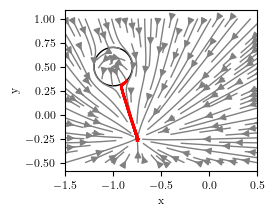

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "8"
from matplotlib import rc

rc('text', usetex=True)
# for j in range(n): # will be out of memory
# for j in range(1):
fig_width = 90/25.4  * 0.7
fig, ax = plt.subplots(figsize=(fig_width, fig_width))



# ax.scatter(r.x_obj[2][0], r.x_obj[2][1], c = 'b', s=10)
# ax.scatter(r.x_obj[3][0], r.x_obj[3][1], c = 'b', s=10)
ax.scatter(attractor_1[0], attractor_1[1], c = 'r', s=10,marker="*",zorder=100)
# for i in range(2):
#     circle = np.vstack([np.cos(np.linspace(0,np.pi*2, 300)) * radius, np.sin(np.linspace(0,np.pi*2, 300)) * radius]).T + r.x_obj[2+i][:2].reshape(1,-1)
#     ax.plot(circle[:,0], circle[:,1], c='k', linewidth=1)

for i in range(1):
    circle = np.vstack([np.cos(np.linspace(0,np.pi*2, 300)) * radius, np.sin(np.linspace(0,np.pi*2, 300)) * radius]).T + r.x_obj[0][:2].reshape(1,-1)
    ax.plot(circle[:,0], circle[:,1], c='k', linewidth=1)

ax.streamplot(x[:,:], y[:,:], vel[:,:,0], vel[:,:,1], density=[1, 1], linewidth=1, minlength=0.05,color='gray') # screamlines for DS in 2D
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_aspect('equal', adjustable='box')
# add the test point traj
ax.scatter(x0_traj[:,0], x0_traj[:,1], s=0.1, c='r', zorder=100)
# ax.scatter(x0[0], x0[1], c = 'b', s=10, marker='.', zorder=100)


fig.savefig('DS_test.jpg',format='jpg', bbox_inches='tight',  pad_inches=0.0, dpi=600)

In [11]:
vector = [1,2,3,4,5,0.5]
np.nonzero(np.array(vector) <1)[0][0]

5

In [12]:
# from sympy import *
# x, y, r = symbols('x y r')
# a,b, phi = symbols('a b, phi')
# init_printing(use_unicode=True)


In [13]:
# phi = (sy.sqrt((x-a)**2 + (y-b) **2)  - r) * phi
# diff(phi, x)

In [14]:
# diff(phi, y)

In [15]:
# import sympy as sy
# phi_ = sy.lambdify([[x, y,a,b,r]], phi)
# d_phi_x = sy.lambdify([[x, y,a,b,r]], diff(phi, x))
# d_phi_y = sy.lambdify([[x, y,a,b,r]], diff(phi, y))

In [16]:
# phi_([1,2,3,4,0.1])

In [17]:
# d_phi_x([1,2,3,4,0.1])